# N-Body Simulator (Library)

In [40]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import random
import pandas as pd

## Particle class
Each object in the N-Body Simulator is defined by a particle object which has the properties: mass, position, velocity, radius and colour. The current version of the program works by calculating the resultant forces acting on each particle from finding the impact of the gravitational forces from all other particles in the system. 

The ```find_components()``` function will find out the direction of each force acting on the particle. 

The ```collision()``` function determines if two bodies are about to collide and if so, they merge into one particle with an increased radius, mass and combined density. 

The ```force()``` function will calculate the force applied to the particle and work out the new velocity of the particle as a result of the gravitational influence of the other particle. 

The ```move()``` function will simply move the particle once the resultant force has been calculated for that particle. 

In [41]:
class particle:
    def __init__(self, mass, position, velocity, radius, colour):
        self.mass = mass
        self.position = position
        self.velocity = velocity
        self.radius = radius
        self.colour = colour
        self.density = (3*self.mass)/(4*np.pi*(self.radius**3))
        self.position_store_x, self.position_store_y, self.position_store_z = [],[],[]
    def find_components(self, force, separation, other):
        r = self.position-other.position
        direction = -(r/separation)
        force_vector = direction*force
        return force_vector
    def collision(self, separation, other, particle_list):
        if(self.radius + other.radius > separation):
            momentum = (self.velocity*self.mass) + (other.velocity*other.mass)
            self.density = (other.mass/(self.mass+other.mass))*other.density + (self.mass/(self.mass+other.mass))*self.density
            self.mass += other.mass
            self.velocity = momentum/self.mass
            self.radius = ((3*self.mass)/(4*np.pi*self.density))**(1/3)
            particle_list[particle_list.index(other)] = None
            return True
        else:
            return False
    def force(self, other, delta_time, particle_list):
        separation = np.sqrt((self.position[0] - other.position[0])**2 + (self.position[1] - other.position[1])**2)
        if(not self.collision(separation, other, particle_list)):
            force = ((6.67*10**-11)*self.mass*other.mass)/(separation)**2
            force_vector = self.find_components(force, separation, other)
            self.velocity = self.velocity + ((force_vector/self.mass)*delta_time)
    def move(self, delta_time):
        self.position = self.position + self.velocity*delta_time
        self.position_store_x.append(self.position[0])
        self.position_store_y.append(self.position[1])
        self.position_store_z.append(self.position[2])

## Setup mode 1 (random)
One of the ways in which the particles can be generated is via a random plotting of points according to a set of 'bounds' determined by the user. 

In [42]:
def random_particles(mass_lower, mass_upper, pos_bounds, rad_lower, rad_upper, number_particles):
    particles = []
    for i in range(number_particles):
        particles.append(particle(random.uniform(mass_lower, mass_upper), np.array([random.uniform(-pos_bounds,pos_bounds),random.uniform(-pos_bounds,pos_bounds),random.uniform(-pos_bounds,pos_bounds)]), np.array([0,0,0]), random.uniform(rad_lower, rad_upper), 'black'))
    return particles, True

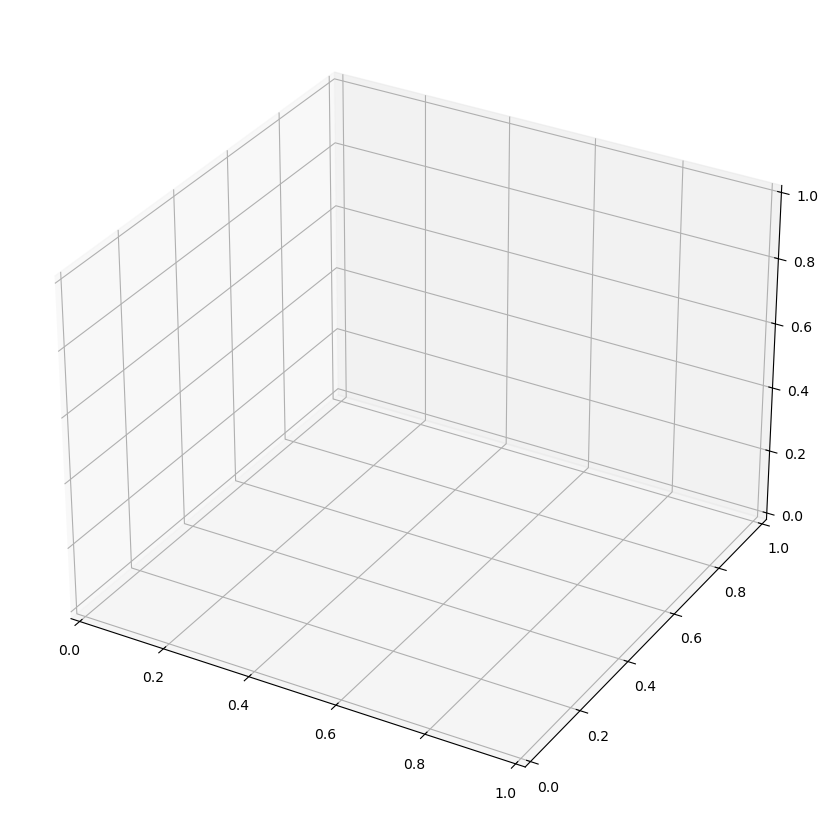

In [43]:
mass_lower = 10**19
mass_upper = 10**23
pos_bounds = 2*10**7
rad_upper = 250000
rad_lower = 10000
number_particles = 30
particles, random_state = random_particles(mass_lower, mass_upper, pos_bounds, rad_lower, rad_upper, number_particles)
size_scale = 800
tail_length = 25
period = 2000
delta_time = 50

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.set_size_inches(10.5, 10.5)

## Setup mode 2 (from spreadsheet)
The other way in which the particles can be generated is from a spreadsheet which the user can import. The spreadsheet must contain the columns: mass, x_position, y_position, x_velocity, y_velocity, radius and colour. Setting the radius to 1 will ignore collisions. 

In [44]:
def load_from_spreadsheet(file_name):
    bodies = pd.read_csv(file_name)
    particles = []
    for i in range(len(bodies)):
        particles.append(particle(float(bodies['mass'][i]), np.array([float(bodies['x_position'][i]), float(bodies['y_position'][i]),float(bodies['z_position'][i])]), np.array([float(bodies['x_velocity'][i]), float(bodies['y_velocity'][i]),float(bodies['z_velocity'][i])]), float(bodies['radius'][i]), bodies['colour'][i]))
    return particles, False, len(bodies)

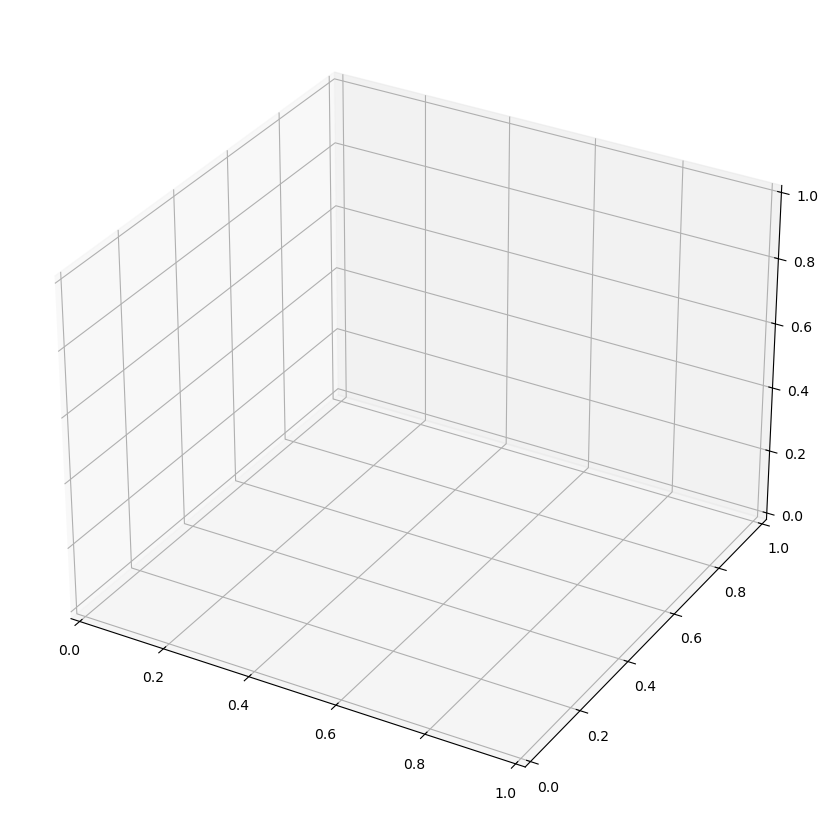

In [45]:
file_name = 'Sol.csv'
particles, random_state, number_particles = load_from_spreadsheet(file_name)
size_scale = 800
tail_length = 50
period =  
delta_time =86400
pos_bounds = 3*10**11

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.set_size_inches(10.5, 10.5)

## Frame update sequence
The ```update()``` function will run the simulation and update each frame to show the new position of the particles. This function sets up the axis so that the axis arent visible, set the limits for the x and y axis, and produces a title for each frame depending on the day being shown. It will also call the ```force()``` and ```move()``` functions for each particle to find their new positions and plot them accordingly (as well as add a tail to each object assuming that the tail length is greater than 0). 

In [46]:
def update(frame):
    ax.cla()
    if random_state:
        ax.set_title(str(number_particles)+'-body simulation, time: '+str('{0:.2f}'.format((frame*delta_time)/86400))+' days')
    else:
        ax.set_title('File: '+str(file_name)+', time: '+str('{0:.2f}'.format((frame*delta_time)/86400))+' days')
    ax.set_xlim(-pos_bounds, pos_bounds)
    ax.set_ylim(-pos_bounds, pos_bounds)
    ax.set_zlim(-pos_bounds, pos_bounds)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.get_zaxis().set_visible(False)
    x_positions, y_positions, z_positions = [],[],[]
    sizes = []
    colours = []
    for j in range(number_particles):
        for h in range(number_particles):
            if h != j and particles[j] != None and particles[h] != None:
                particles[j].force(particles[h], delta_time, particles)
    for j in range(number_particles):
        if particles[j] != None:
            particles[j].move(delta_time)
            x_positions.append(particles[j].position[0])
            y_positions.append(particles[j].position[1])
            z_positions.append(particles[j].position[2])
            colours.append(particles[j].colour)
            if particles[j].radius == 1:
                sizes.append(10)
            else:
                sizes.append((particles[j].radius/pos_bounds) * size_scale)
            if frame >= tail_length:
                ax.plot(particles[j].position_store_x[frame-tail_length:frame+2], particles[j].position_store_y[frame-tail_length:frame+2], particles[j].position_store_z[frame-tail_length:frame+2], color=particles[j].colour)
            else:
                ax.plot(particles[j].position_store_x[0:frame], particles[j].position_store_y[0:frame], particles[j].position_store_z[0:frame], color=particles[j].colour)
    ref = ax.scatter(x_positions, y_positions, z_positions, s=sizes, color=colours)
    return ref

## Animation generation
Lastly, using ```matplotlib.animation.FuncAnimation()```, the animiation is generated and saved as an mp4.

In [47]:
anim = FuncAnimation(fig, update, frames = period, blit = False, interval = 1)

if random_state:
    anim.save('Nbody-'+str(number_particles)+'.mp4', fps=30)
else:
    anim.save(file_name+'.mp4', fps=30)